In [40]:
cd("C:/Users/User/Downloads")

In [41]:
using CSV
using DataFrames

# Read the CSV file into a DataFrame
df = CSV.read("online_discounts.csv", DataFrame,
              types = Dict(:device => String, :browser => String, :region => String));
              
# Display the first few rows of the DataFrame
first(df, 5)

Row,Column1,time,device,browser,region,discount,spend
,Int64,Float64,String,String,String,Int64,Float64
1,0,10.779,mobile,edge,9,0,0.455164
2,1,0.568973,desktop,firefox,9,0,11.0369
3,2,3.74387,mobile,safari,7,0,1.81119
4,3,13.3734,desktop,other,5,0,31.9049
5,4,0.708575,mobile,explorer,2,1,15.4199


In [42]:
using GLM
using DataFrames

# Assuming df is already a DataFrame
# Fit the linear model
model = lm(@formula(spend ~ discount), df)

# Display the summary of the model
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spend ~ 1 + discount

Coefficients:
────────────────────────────────────────────────────────────────────────
               Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  5.12207   0.0454349  112.73    <1e-99    5.03302    5.21112
discount     1.75069   0.0642194   27.26    <1e-99    1.62482    1.87656
────────────────────────────────────────────────────────────────────────

In [43]:
using GLM
using DataFrames

# Assuming df is already a DataFrame
# Fit the linear model with interaction term between discount and device
model = lm(@formula(spend ~ discount * device), df)

# Display the summary of the model
model

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

spend ~ 1 + discount + device + discount & device

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                               Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                5.07574     0.0640853  79.20    <1e-99   4.95013     5.20135
discount                   1.08963     0.0906575  12.02    <1e-32   0.911944    1.26732
device: mobile             0.0929325   0.0907603   1.02    0.3059  -0.0849567   0.270822
discount & device: mobile  1.32109     0.128284   10.30    <1e-24   1.06966     1.57253
────────────────────────────────────────────────────────────────────────────────────────

In [46]:
using MLJ

y, X = unpack(df, ==(:spend), !=(:spend))
coerce!(X, Textual => Multiclass)
coerce!(X, Count => Multiclass)

Row,Column1,time,device,browser,region,discount
,Cat…,Float64,Cat…,Cat…,Cat…,Cat…
1,0,10.779,mobile,edge,9,0
2,1,0.568973,desktop,firefox,9,0
3,2,3.74387,mobile,safari,7,0
4,3,13.3734,desktop,other,5,0
5,4,0.708575,mobile,explorer,2,1
6,5,10.8321,desktop,brave,0,0
7,6,22.0928,desktop,safari,0,1
8,7,14.8808,desktop,chrome,3,0
9,8,11.1469,desktop,safari,2,0


In [47]:
D, X = unpack(X, ==(:discount), !=(:discount))

(CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 0, 0, 0, 1, 0, 1, 0, 0, 1  …  1, 0, 1, 1, 0, 0, 0, 0, 0, 1], 100000×5 DataFrame
    Row │ Column1  time       device   browser   region 
        │ Cat…     Float64    Cat…     Cat…      Cat…   
────────┼───────────────────────────────────────────────
      1 │ 0        10.779     mobile   edge      9
      2 │ 1         0.568973  desktop  firefox   9
      3 │ 2         3.74387   mobile   safari    7
      4 │ 3        13.3734    desktop  other     5
      5 │ 4         0.708575  mobile   explorer  2
      6 │ 5        10.8321    desktop  brave     0
      7 │ 6        22.0928    desktop  safari    0
      8 │ 7        14.8808    desktop  chrome    3
   ⋮    │    ⋮         ⋮         ⋮        ⋮        ⋮
  99994 │ 99993    16.0944    desktop  edge      3
  99995 │ 99994     3.57947   desktop  chrome    4
  99996 │ 99995    14.2243    desktop  firefox   9
  99997 │ 99996    15.8043    desktop  other     5
  99998 │ 99997     2.36471   

In [48]:
using MLJModels


onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:device, :browser, :region])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

X = X[:,2:end]

┌ Info: Training machine(OneHotEncoder(features = [:device, :browser, :region], …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Spawning 2 sub-features to one-hot encode feature :device.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878
┌ Info: Spawning 7 sub-features to one-hot encode feature :browser.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878
┌ Info: Spawning 10 sub-features to one-hot encode feature :region.
└ @ MLJModels C:\Users\User\.julia\packages\MLJModels\ziReN\src\builtins\Transformers.jl:878


Row,time,device__desktop,device__mobile,browser__brave,browser__chrome,browser__edge,browser__explorer,browser__firefox,browser__other,browser__safari,region__0,region__1,region__2,region__3,region__4,region__5,region__6,region__7,region__8,region__9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,10.779,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.568973,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.74387,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,13.3734,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.708575,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.8321,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,22.0928,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,14.8808,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,11.1469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface

log_model = LogisticClassifier()

log_model_machine = machine(log_model,X, D)

fit!(log_model_machine)

import MLJScikitLearnInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\User\.julia\packages\MLJModels\ziReN\src\loading.jl:159


┌ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
└ @ MLJBase C:\Users\User\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
C:\Users\User\.julia\environments\v1.10\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @123 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @674 ⏎ AbstractVector{Multiclass{2}}


In [74]:
pdf.(MLJ.predict(log_model_machine, X),1)

100000-element Vector{Float64}:
 0.5142146419087926
 0.5100085364972161
 0.49702531576346043
 0.4879660329572406
 0.5109496741490348
 0.5075633487291222
 0.5004810026849342
 0.5016481873441815
 0.4997925159452702
 0.49541904576951884
 ⋮
 0.4891853186539567
 0.4995247634315574
 0.5045728007984978
 0.5087262134483533
 0.5065792652936659
 0.4873557804652629
 0.5031095211499076
 0.5119182452419018
 0.5100448975009242

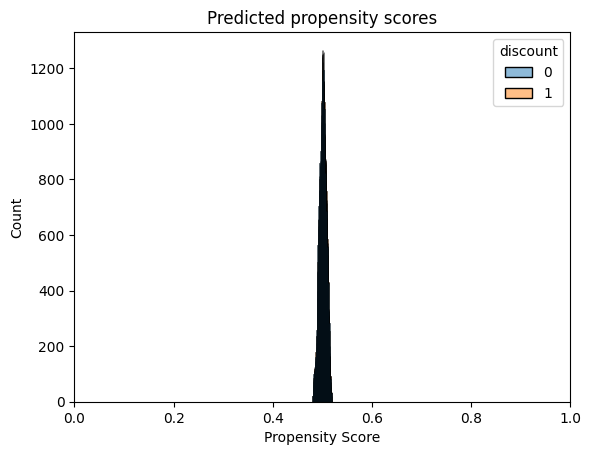

In [ ]:
from sklearn.linear_model import LogisticRegression
import seaborn as sns

df['pscore'] = LogisticRegression().fit(df[X], df['discount']).predict_proba(df[X])[:,1]
sns.histplot(data=df, x='pscore', hue='discount').set(
    title='Predicted propensity scores', xlim=[0,1], xlabel='Propensity Score')
plt.show()

In [ ]:
df['y_star'] = df['spend'] / (df['discount'] * df['pscore'] - (1-df['discount']) * (1-df['pscore']))

In [ ]:
df['y_star'].mean()

1.757432826389853

In [ ]:
X

['time',
 'device_mobile',
 'browser_chrome',
 'browser_edge',
 'browser_explorer',
 'browser_firefox',
 'browser_other',
 'browser_safari',
 'region_1',
 'region_2',
 'region_3',
 'region_4',
 'region_5',
 'region_6',
 'region_7',
 'region_8',
 'region_9']

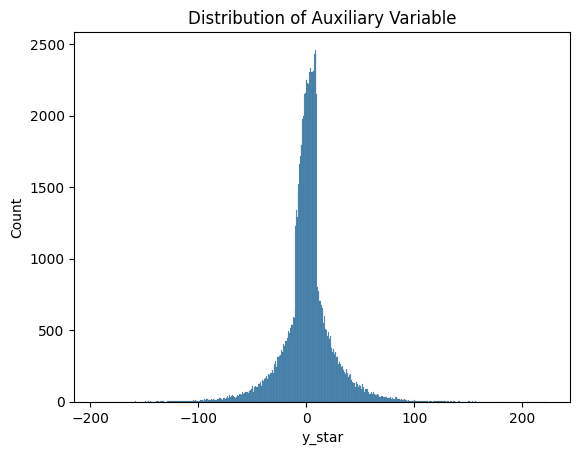

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(df['y_star'], ax=ax).set(title='Distribution of Auxiliary Variable')
plt.show()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star'])
df['y_hat'] = tree.predict(df[X])

In [ ]:
df[X].shape

(100000, 17)

In [ ]:
DecisionTreeRegressor = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)
tree_model = DecisionTreeRegressor(max_depth=2)
tree_machine = machine(tree_model,, )
fit!(tree_machine);


,Unnamed: 0,time,device,browser,region,discount,spend,device_mobile,browser_chrome,browser_edge,...,region_3,region_4,region_5,region_6,region_7,region_8,region_9,pscore,y_star,y_hat
0,0,10.779006,mobile,edge,9,0,0.455164,True,False,True,...,False,False,False,False,False,False,True,0.514231,-0.936998,1.199537
1,1,0.568973,desktop,firefox,9,0,11.036871,False,False,False,...,False,False,False,False,False,False,True,0.509986,-22.523575,0.126840
2,2,3.743871,mobile,safari,7,0,1.811193,True,False,False,...,False,False,False,False,True,False,False,0.497636,-3.605339,0.126840
3,3,13.373436,desktop,other,5,0,31.904944,False,False,False,...,False,False,True,False,False,False,False,0.487991,-62.313230,2.762929
4,4,0.708575,mobile,explorer,2,1,15.419862,True,False,False,...,False,False,False,False,False,False,False,0.511283,30.159140,0.126840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,14.224321,desktop,firefox,9,0,34.047518,False,False,False,...,False,False,False,False,False,False,True,0.506558,-69.000012,2.762929
99996,99996,15.804262,desktop,other,5,0,13.277267,False,False,False,...,False,False,True,False,False,False,False,0.487381,-25.900839,2.762929
99997,99997,2.364713,desktop,safari,9,0,13.237008,False,False,False,...,False,False,False,False,False,False,True,0.503527,-26.662070,0.126840
99998,99998,3.723502,desktop,edge,4,0,0.202660,False,False,True,...,False,True,False,False,False,False,False,0.511564,-0.414916,0.126840


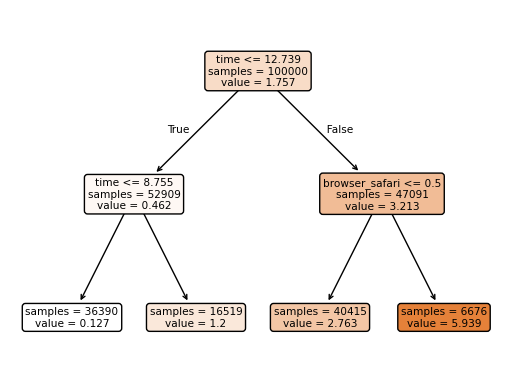

In [ ]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True, feature_names=X, impurity=False, rounded=True)
plt.show()

In [ ]:
from econml.dml import CausalForestDML
import numpy as np 
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df['spend'], X=df[X], T=df['discount'])

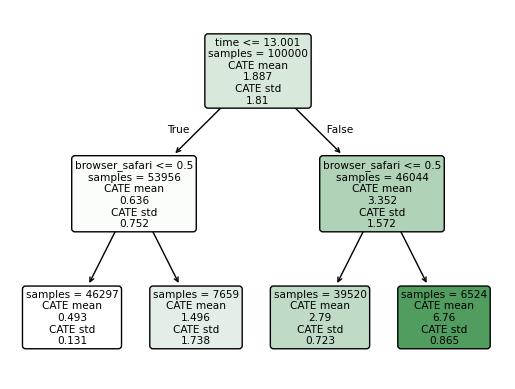

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X)
plt.show()